<h2 style='color:blue' align='center'>Sports Celebrity Image Classification<h2>

In [1]:
import pandas as pd 
import numpy as np
import cv2  as cv
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline


<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>

#### Now how do you detect face and eyes?

In [2]:
#img = cv.imread('./test_images/Kritk.jpg')
img = cv.imread('./test_images/10031.jpg')
#img = cv.imread('./test_images/sharapova1.jpg')

img.shape

(275, 183, 3)

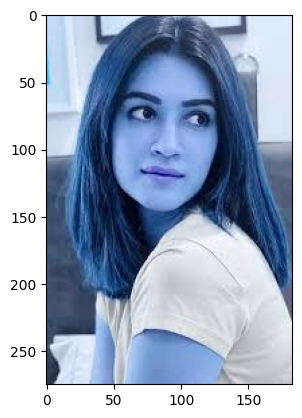

In [3]:
plt.imshow(img)

In [4]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray.shape

(275, 183)

In [5]:
gray

array([[225, 225, 225, ..., 238, 238, 238],
       [225, 225, 225, ..., 238, 238, 238],
       [225, 225, 225, ..., 238, 238, 238],
       ...,
       [ 54,  60,  67, ..., 202, 202, 202],
       [ 62,  65,  61, ..., 200, 200, 200],
       [ 65,  70,  57, ..., 197, 197, 197]], shape=(275, 183), dtype=uint8)

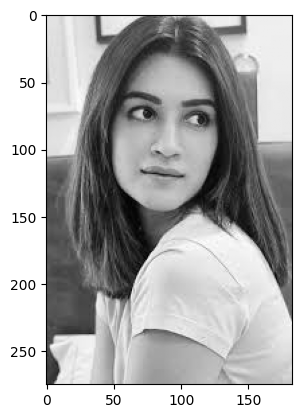

In [6]:
plt.imshow(gray,cmap='gray')

In [7]:
#load pre-trained classifiers
face_cascade = cv.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
#detect faces
faces = face_cascade.detectMultiScale(gray, 1.3,5)
faces

array([[ 40,  39, 101, 101]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]


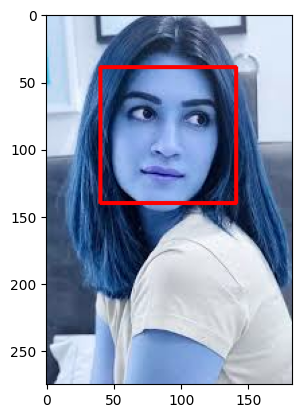

In [9]:
face_img = cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

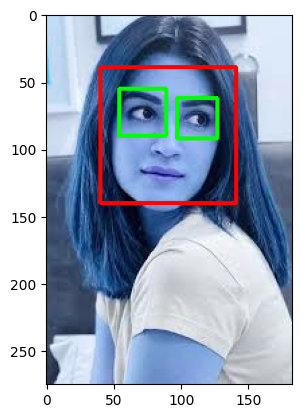

In [10]:
cv.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = face_img[y:y+h,x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


plt.figure()
plt.imshow(face_img,cmap='gray')
plt.show()

<h3 style='color:purple'>(2) Preprocessing: Crop the facial region of the image</h3>

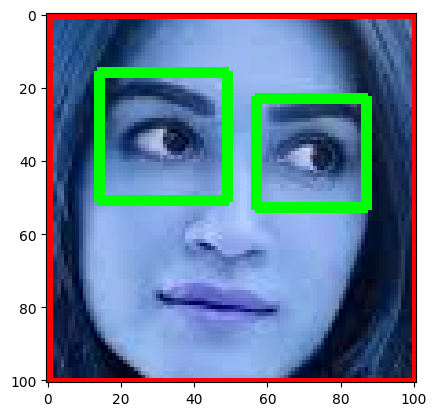

In [11]:
plt.imshow(roi_color,cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(101, 101, 3)

<h3 style='color:purple'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [13]:
import numpy as np
import pywt 

def w2d(img, mode='haar' , level=1):
    imArray = img
    #datatype conversion
    #convert to gray scale
    imArray = cv.cvtColor(imArray,cv.COLOR_BGR2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /=255
    #compute coefficients
    coeffs = pywt.wavedec2(imArray,mode,level=level)

    #process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    #reconstruction
    imArray_H = pywt.waverec2(coeffs_H,mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)

    return imArray_H



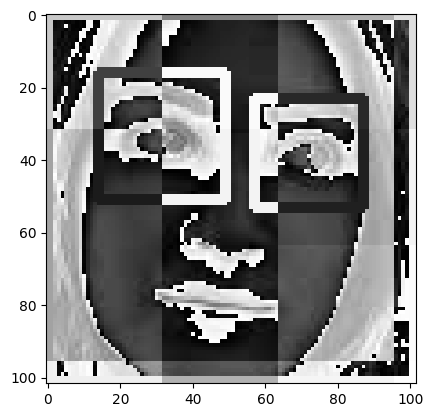

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har,cmap='gray')


#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv.imread(image_path)
    # Check if the image is loaded correctly
    if img is None:
        print(f"Error loading image: {image_path}")
        return None
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color

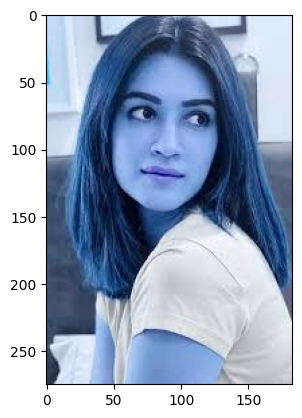

In [16]:
original_image = cv.imread('./test_images/10031.jpg')
plt.imshow(original_image)

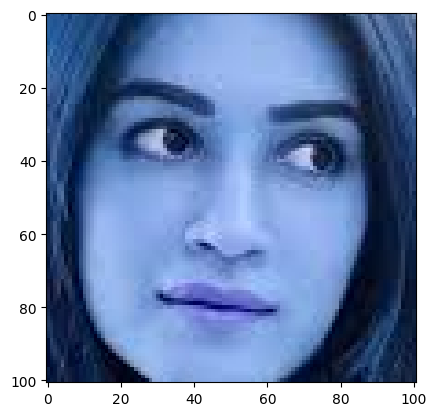

In [17]:
cropped_image= get_cropped_image_if_2_eyes('./test_images/10031.jpg')
plt.imshow(cropped_image)

**In below image face is not very clear and it doesn't have two eyes clearly visible**

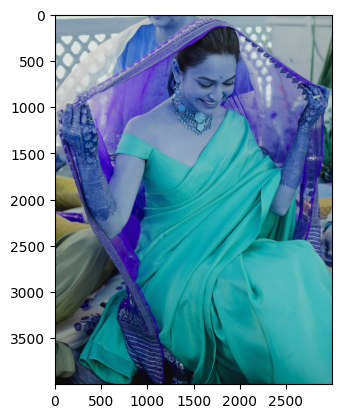

In [18]:
original_image_obst = cv.imread('./test_images/10091.jpg')
plt.imshow(original_image_obst)

In [19]:
cropped_image_on_2_eye = get_cropped_image_if_2_eyes('./test_images/10091.jpg')
cropped_image_on_2_eye

**Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training**

In [20]:
path_to_data = './datasets/'
path_to_cr_data = './datasets/cropped/'

In [21]:
import os 
img_dirs = []
cropped = 'cropped'
for entry in os.scandir(path_to_data):
    if entry.is_dir() :
        if entry == cropped:
            continue
        else:
            print(entry)
            img_dirs.append(entry.path)

<DirEntry 'virat_kohli'>
<DirEntry 'kriti_kharbanda'>
<DirEntry 'rajkummar_rao'>
<DirEntry 'ayushmann_khurrana'>
<DirEntry 'kriti_sanon'>


In [22]:
img_dirs

['./datasets/virat_kohli',
 './datasets/kriti_kharbanda',
 './datasets/rajkummar_rao',
 './datasets/ayushmann_khurrana',
 './datasets/kriti_sanon']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [23]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [24]:
cropped_image_dirs = []
celebrity_file_namees_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    #print(celebrity_name)
    celebrity_file_namees_dict[celebrity_name]=[]
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images... in folder:",cropped_folder)   
            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = cropped_folder +'/' + cropped_file_name
            cv.imwrite(cropped_file_path,roi_color)
            celebrity_file_namees_dict[celebrity_name].append(cropped_file_path)
            count += 1



Generating cropped images... in folder: ./datasets/cropped/virat_kohli
Error loading image: ./datasets/virat_kohli/10238.gif
Error loading image: ./datasets/virat_kohli/10204.gif
Generating cropped images... in folder: ./datasets/cropped/kriti_kharbanda
Generating cropped images... in folder: ./datasets/cropped/rajkummar_rao
Generating cropped images... in folder: ./datasets/cropped/ayushmann_khurrana
Generating cropped images... in folder: ./datasets/cropped/kriti_sanon


### Now you should have cropped folder under datasets folder that contains cropped images

### Manually examine cropped folder and delete any unwanted images

In [25]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'virat_kohli': ['./datasets/cropped/virat_kohli/virat_kohli24.png',
  './datasets/cropped/virat_kohli/virat_kohli14.png',
  './datasets/cropped/virat_kohli/virat_kohli39.png',
  './datasets/cropped/virat_kohli/virat_kohli37.png',
  './datasets/cropped/virat_kohli/virat_kohli7.png',
  './datasets/cropped/virat_kohli/virat_kohli8.png',
  './datasets/cropped/virat_kohli/virat_kohli3.png',
  './datasets/cropped/virat_kohli/virat_kohli6.png',
  './datasets/cropped/virat_kohli/virat_kohli21.png',
  './datasets/cropped/virat_kohli/virat_kohli19.png',
  './datasets/cropped/virat_kohli/virat_kohli23.png',
  './datasets/cropped/virat_kohli/virat_kohli27.png',
  './datasets/cropped/virat_kohli/virat_kohli40.png',
  './datasets/cropped/virat_kohli/virat_kohli34.png',
  './datasets/cropped/virat_kohli/virat_kohli20.png',
  './datasets/cropped/virat_kohli/virat_kohli35.png',
  './datasets/cropped/virat_kohli/virat_kohli29.png',
  './datasets/cropped/virat_kohli/virat_kohli4.png',
  './datasets/crop

In [26]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_namees_dict.keys():
    if celebrity_name == 'cropped':
        continue
    else:
        class_dict[celebrity_name] = count
        count += 1

class_dict

{'virat_kohli': 0,
 'kriti_kharbanda': 1,
 'rajkummar_rao': 2,
 'ayushmann_khurrana': 3,
 'kriti_sanon': 4}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [27]:
X = []
y = []
for celebrity_name,training_files in celebrity_file_namees_dict.items():
    for training_image in training_files:
        img =cv.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv.resize(img_har,(32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

        


In [28]:
len(X)

283

In [29]:
len(X[0])

4096

In [30]:
X= np.array(X).reshape(len(X),4096).astype(float)
X.shape

(283, 4096)

#### Data cleaning process is done. Now we are ready to train our model

We Will SVM with rbf kernel tuned with heuristic finetuning

In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [32]:
X_train, X_test,y_train,y_test = train_test_split(X,y,random_state =42)

pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel = 'rbf',C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7183098591549296

In [33]:
len(X_test)

71

In [34]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.75      0.71      0.73        17
           2       0.75      0.60      0.67        15
           3       0.67      0.77      0.71        13
           4       0.64      0.69      0.67        13

    accuracy                           0.72        71
   macro avg       0.72      0.72      0.72        71
weighted avg       0.72      0.72      0.72        71



#### Let's use GridSearch to try out different models with different paramests. Goal is to come up with best model with best fine tuned parameters

In [35]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [36]:
model_params = {
    'svm':{
        'model': svm.SVC(gamma='auto',probability=True),
        'params':{
        'svc__C':[1,10,100,1000],
        'svc__kernel':['rbf','linear']
        }
    },
    'random_forest': {
        'model':RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators':[1,5,10]
        }
    },
    'logistic_regression':{
        'model':LogisticRegression(),
        'params':{}
    }
 

}




In [37]:
scores = []
best_estimators = {}
import pandas as pd
for algo,mp in model_params.items():
    pipe=make_pipeline(StandardScaler(),mp['model'])
    clf = GridSearchCV(pipe,mp['params'],cv = 5,return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model':algo,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.627353,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.476633,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.660687,{}


In [38]:
best_estimators['svm'].score(X_test,y_test)

0.7323943661971831

In [39]:
best_estimators['random_forest'].score(X_test,y_test)

0.647887323943662

In [40]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7183098591549296

In [41]:
best_clf = best_estimators['svm']

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,best_clf.predict(X_test))
cm

array([[11,  0,  0,  2,  0],
       [ 0, 14,  0,  0,  3],
       [ 1,  2,  8,  4,  0],
       [ 2,  0,  1, 10,  0],
       [ 1,  3,  0,  0,  9]])

Text(95.72222222222221, 0.5, 'Truth')

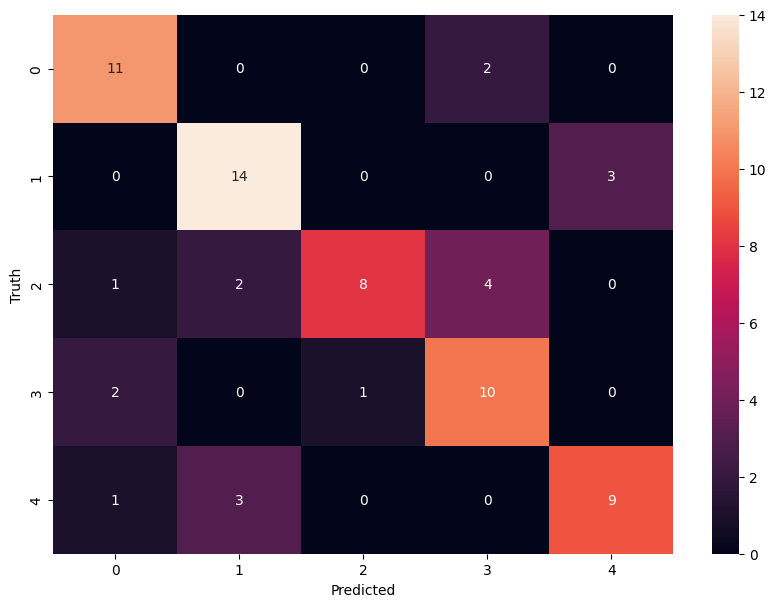

In [43]:
import seaborn as sns 
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot = True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [44]:
class_dict

{'virat_kohli': 0,
 'kriti_kharbanda': 1,
 'rajkummar_rao': 2,
 'ayushmann_khurrana': 3,
 'kriti_sanon': 4}

### Save the trained model

In [45]:
import joblib 
#save the model as a pickel ina file
joblib.dump(best_clf,'saved_model.pkl')


['saved_model.pkl']

### Save class dictionary

In [46]:
import json
with open("class_dictionary.json",'w') as f:
    f.write(json.dumps(class_dict))